# Rendu Projet IAS, 2023
# EEG BCI

##### Auteurs: James Camilleri, Badreddine Channoufi, Adam Sekkat, Victor Robert--Lambrecht

<u>Summary:</u>
- [Data extraction, and overview of the dataset](#Data_extraction)
- [Classification](#Classification)
    - [Classify people](#Classify_people)
        - [Some data visualisation](#Some_data_visualisation)
        - [A first step towards classification](#A_first_step_towards_classification)
        - [Improving the QDA classifier](#Improving_the_QDA_classifier)
        - [Coding the QDA classifier](#Coding_the_QDA_classifier)
        - [Multiple electrodes](#Multiple_electrodes)
    - [Classify tasks](#Classify_tasks)
        - [Using raw data for classification](#Using_raw_data_for_classification)
        - [Feature extraction](#Feature_extraction)
           - [Fourier transform](#Fourier_transform)
           - [PSD: Power spectral density](#PSD:_Power_spectral_density)
           - [PCA: Principal component analysis](#PCA:_Principal_component_analysis)
           - [Image processing](#Image_processing)
              - [Deep convolutional neural network](#Deep_convolutional_neural_network)
              - [Reducing overfiting](#Reducing_overfitting)
        
- [Additional work](#Additional_work)
    - [Compressed sensing of eeg data](#Compressed_sensing)
    - [Video](#Video)
    
Note that this project was written in English.<br><b> We do not recommend running the code as it is sometimes very slow, and some additional modules would have to be installed.</b> <br>The work was distributed equally among the four authors.

***

<a id='Data_extraction'></a>
## Data extraction

Let's start by importing the necessary libraries for plotting and maths

In [272]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

We now import the module that allows us to access the data

In [273]:
import moabb
from moabb.datasets import utils
from moabb.datasets import BNCI2014001
moabb.set_log_level("info")

We will be using the following dataset: BNCI2014001, which we will download and extract.

Here is the structure of the dataset:
- It is composed of 9 subjects
- Each subject has 2 sessions
- Each session has 6 runs
- Each run has 48 trials
- Each trial has 4 classes: left hand, right hand, feet, tongue
- The data is sampled at 250Hz
- The data was recorded with 26 electrodes, 22 active electrodes

This dataset is presented in more detail in the following article:  **Tangermann, M., Müller, K.R., Aertsen, A., Birbaumer, N., Braun, C., Brunner, C., Leeb, R., Mehring, C., Miller, K.J., Mueller-Putz, G. and Nolte, G., 2012. Review of the BCI competition IV. Frontiers in neuroscience, 6, p.55.**

In [274]:
dataset = BNCI2014001() #utils.dataset_search(paradigm='imagery')[0] #AlexMi dataset
dataset.download()

The data variable contains the data for all subjects ! 

In [275]:
data = dataset.get_data()

***

<a id='Classification'></a>
## Classification

Now that we have the data we can start to classify it. We will start with the easy task, that is to classify people, and then we will attempt to classify the tasks.

<a id='Classify_people'></a>

### Classify people

We have not yet worked with EEG data and therefore do not know how to process it efficiently.
Therefore, we will start by trying to use many different classifiers and see which one works best, interpret the results and then try to improve them. We will not extract features from the data, but rather use the raw data at first. As you will see this is enough for some classifiers to work well.

Let's start by importing the necessary classifiers

In [276]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis,LinearDiscriminantAnalysis

Let's give all of them a name so that we can easily identify them later

In [277]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "LDA"
]

We will initialize all of the classifiers with their default/usual parameters

In [278]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LinearDiscriminantAnalysis()
]

As a warm up we will classify two people ! We will start by extracting the data of the two people. 
We fuse the two sessions as to have more data ! 

In [279]:
Data_subjects = [data[i]['session_T']['run_0']._data + data[i]['session_E']['run_0']._data for i in range(1,len(data)+1)]

Data_subject1, Data_subject2 = Data_subjects[0], Data_subjects[1]

We verify that the data is correct (26 electrodes)

In [280]:
Data_subject1.shape, Data_subject2.shape

((26, 96735), (26, 96735))

Nice ! There are 26 electrodes. For the moment that is too much, let's simplify the task by selecting only one elecrode ! 

In [281]:
Data_subject1_elec = Data_subject1[0]
Data_subject2_elec = Data_subject2[0]

#### Some data visualization

We will start by visualizing the data to get an idea of what we are working with ! But there is too much data ($96735$), let's troncate it and only visualize the first $500$ data points.

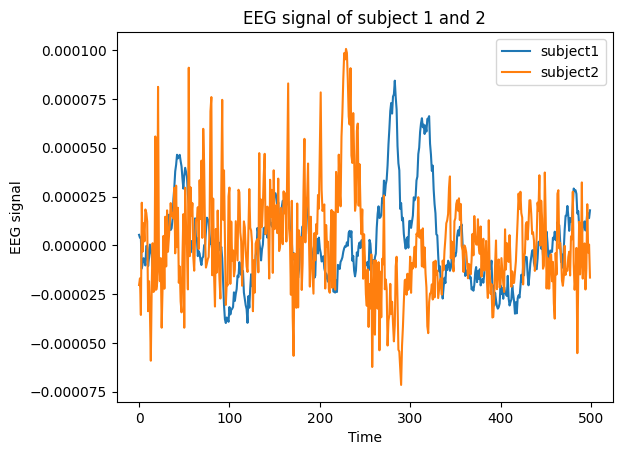

In [282]:
plt.plot(Data_subject1_elec[:500],label='subject1')
plt.plot(Data_subject2_elec[:500],label='subject2')
plt.legend()
plt.xlabel('Time')
plt.ylabel('EEG signal')
plt.title('EEG signal of subject 1 and 2');

Beautiful ! 

***

#### A first step towards classification

Now we have to think about how to differentiate the two people ! <br>
The idea is to create packets of data that have a certain size, and to separate the entire dataset into these little chunks of data.<br> 

Some of these chunks will be from one person, and some from the other. <br>
We will then use these chunks to train our classifier <br>

We will start randomly by choosing a size of $200$ data points. <br>
$200$ does not divide $96735$, that's not a big problem, we will not use 100% of the dataset.

Let's give it a try with a large number of classifiers ! 

In [283]:
taille_echantillon = 200
Data_subject1_elec_arr = [Data_subject1_elec[x*taille_echantillon:(x+1)*taille_echantillon] for x in range(len(Data_subject1_elec)//taille_echantillon)]
Data_subject2_elec_arr = [Data_subject2_elec[x*taille_echantillon:(x+1)*taille_echantillon] for x in range(len(Data_subject2_elec)//taille_echantillon)]

X, y = np.array(Data_subject1_elec_arr+Data_subject2_elec_arr), np.concatenate((np.zeros(len(Data_subject1_elec_arr)),np.ones(len(Data_subject2_elec_arr))))


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

Scores = []
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    Scores.append(score)
    print(f"Classifier {name} has a score of {score}")



Classifier Nearest Neighbors has a score of 0.5567010309278351
Classifier Linear SVM has a score of 0.4896907216494845
Classifier RBF SVM has a score of 0.4896907216494845
Classifier Gaussian Process has a score of 0.5463917525773195
Classifier Decision Tree has a score of 0.4845360824742268
Classifier Random Forest has a score of 0.4639175257731959
Classifier Neural Net has a score of 0.6082474226804123
Classifier AdaBoost has a score of 0.4948453608247423
Classifier Naive Bayes has a score of 0.4020618556701031
Classifier QDA has a score of 0.7731958762886598
Classifier LDA has a score of 0.5051546391752577


<b>Note:</b> If the classifiers responds randomly his score will be $0.5$. Most of the classifiers do not perform better than chance ! 

It seems that the QDA classifier performs the best ! Let's try to improve it by using a different number of chunks.

#### Improving the QDA classifier

Let's change the chunk size and see how it affects the results

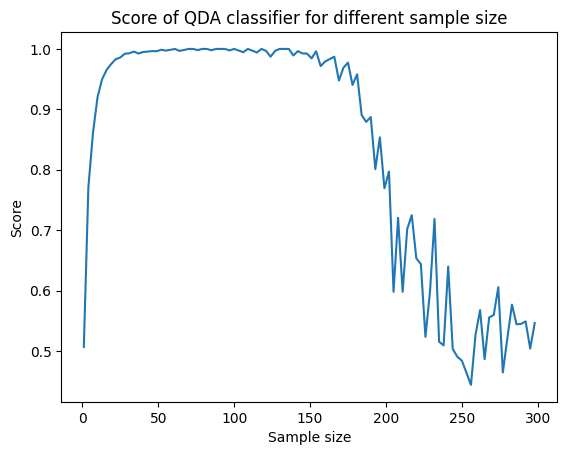

In [284]:
tailles_echantillon = range(1,300,3)
Scores = []
for taille_echantillon  in tailles_echantillon:
    Data_subject1_elec_arr = [Data_subject1_elec[x*taille_echantillon:(x+1)*taille_echantillon] for x in range(len(Data_subject1_elec)//taille_echantillon)]
    Data_subject2_elec_arr = [Data_subject2_elec[x*taille_echantillon:(x+1)*taille_echantillon] for x in range(len(Data_subject2_elec)//taille_echantillon)]

    X, y = np.array(Data_subject1_elec_arr+Data_subject2_elec_arr), np.concatenate((np.zeros(len(Data_subject1_elec_arr)),np.ones(len(Data_subject2_elec_arr))))

    #print(X)
    #print(X.shape, y.shape)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2)

    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    #print(f"Classifier QDA has a score of {score} for {taille_echantillon} samples")
    Scores.append(score)

plt.title('Score of QDA classifier for different sample size')
plt.xlabel('Sample size')
plt.ylabel('Score')
plt.plot(tailles_echantillon,Scores);


The models performance varies greatly as a function of chunk size. We can observe three distinct phases: 
- A first phase where the performance is very low (~50%) for small chunk sizes
- A plateau with an almost perfect socre (~98%), with a chunk size between 40 and 150
- A drop in performance for large chunk sizes

This is a very interesting result ! 

Let's now try to classify all the people ! (9 people)

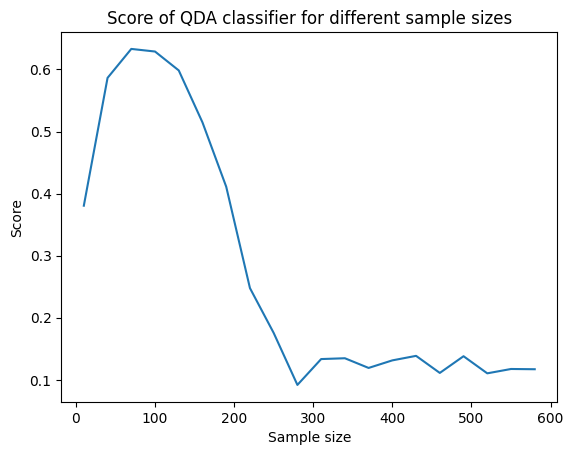

In [285]:
tailles_echantillon = range(10,600,30)
Scores = []

for taille_echantillon  in tailles_echantillon:
    X = []
    for i in range(len(Data_subjects)):
        for x in range(len(Data_subjects[i][0])//taille_echantillon):
            X.append(np.array(Data_subjects[i][0][x*taille_echantillon:(x+1)*taille_echantillon]))

    X = np.array(X)
    y = np.array([[i for j in range(len(Data_subjects[i][0])//taille_echantillon)] for i in range(len(Data_subjects))]).flatten()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    #print(f"Classifier QDA has a score of {score} for {taille_echantillon} sample size")
    Scores.append(score)

plt.plot(tailles_echantillon,Scores)
plt.xlabel('Sample size')
plt.ylabel('Score')
plt.title("Score of QDA classifier for different sample sizes");

Note that the performance has dropped, that's because the classifier has to classify more classes. If it was responding at chance level it would have a score of 1/8. Our score means that it functions properly.

Since the QDA's performance was dependent on the chunk size, it might be the case that other classifiers would also perform really efficiently with a certain chunk size. Let's try to find the best chunk size for each classifier. We will not try this with every classifier, since it would take way too much time. (we tried to run it with all the classifiers, it took a lot of time, and the results were not more interesting)

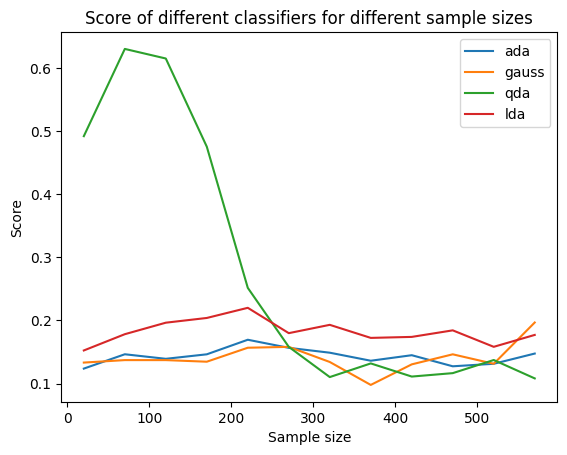

In [286]:
tailles_echantillon = range(20,600,50)
Scores = []

for taille_echantillon  in tailles_echantillon:
    X = []
    for i in range(len(Data_subjects)):
        for x in range(len(Data_subjects[i][0])//taille_echantillon):
            X.append(Data_subjects[i][0][x*taille_echantillon:(x+1)*taille_echantillon])

    
    y = np.array([[i for j in range(len(Data_subjects[i][0])//taille_echantillon)] for i in range(len(Data_subjects))]).flatten()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    Classifier_score = []
    for name, clf in zip(["ada","gauss","qda","lda"], [AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LinearDiscriminantAnalysis()]):
        #clf = clf()
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        #print(f"Classifier {name} has a score of {score} for {taille_echantillon} sample size")
        Classifier_score.append(score)
    Scores.append(Classifier_score)

for i in range(4):
    c_score = [x[i] for x in Scores]
    plt.plot(tailles_echantillon,c_score,label=["ada","gauss","qda","lda"][i])

plt.title("Score of different classifiers for different sample sizes")
plt.xlabel("Sample size")
plt.ylabel("Score")
plt.legend();

QDA works best again ! Other classifiers are not dependent on the chunk size for performance.

#### Coding the QDA classifier

We now code the QDA ourselves ! 

In [287]:
import numpy as np
from scipy.stats import multivariate_normal

class QDA:
    def __init__(self):
        self.parameters = []

    def _compute_parameters(self, X, y):
        unique_labels = np.unique(y)
        parameters = []

        for label in unique_labels:
            X_label = X[y == label]
            mean = np.mean(X_label, axis=0)
            cov = np.cov(X_label.T)
            prior = X_label.shape[0] / X.shape[0]

            parameters.append({
                "label": label,
                "mean": mean,
                "cov": cov,
                "prior": prior,
                "mvn": multivariate_normal(mean=mean, cov=cov,allow_singular=True) #if we don't allow singular, we get an error
            })

        return parameters

    def fit(self, X, y):
        self.parameters = self._compute_parameters(X, y)

    def predict(self, X):
        posteriors = []

        for params in self.parameters:
            likelihood = params["mvn"].pdf(X)
            posterior = likelihood * params["prior"]
            posteriors.append(posterior)

        posteriors = np.stack(posteriors, axis=-1)
        predictions = np.argmax(posteriors, axis=1)
        return predictions

    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

Let's compare our model with the one from sklearn

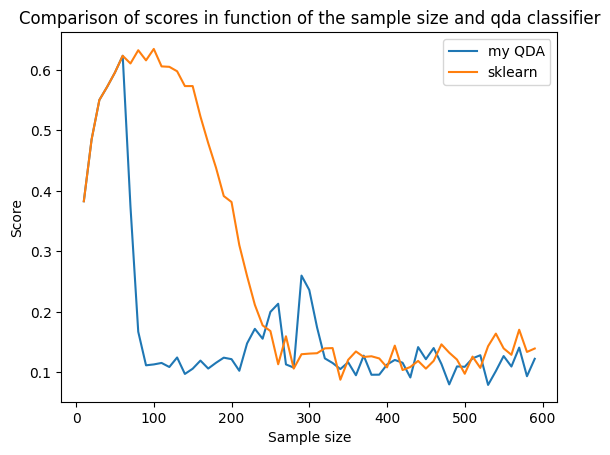

In [288]:
tailles_echantillon = range(10,600,10)
Scores = []

for taille_echantillon  in tailles_echantillon:
    X = []
    for i in range(len(Data_subjects)):
        for x in range(len(Data_subjects[i][0])//taille_echantillon):
            X.append(np.array(Data_subjects[i][0][x*taille_echantillon:(x+1)*taille_echantillon]))
    X = np.array(X)
    y = np.array([[i for j in range(len(Data_subjects[i][0])//taille_echantillon)] for i in range(len(Data_subjects))]).flatten()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    qda1 = QDA()
    qda1.fit(X_train, y_train)
    score1 = qda1.score(X_test, y_test)

    qda2 = QuadraticDiscriminantAnalysis()
    qda2.fit(X_train, y_train)
    score2 = qda2.score(X_test, y_test)
    #print(f"Classifier my_qda has a score of {score1} for {taille_echantillon} sample size")
    #print(f"Classifier sklearn has a score of {score2} for {taille_echantillon} sample size")
    Scores.append([score1,score2])

plt.plot(tailles_echantillon,[Scores[x][0] for x in range(len(Scores))],label="my QDA")
plt.plot(tailles_echantillon,[Scores[x][1] for x in range(len(Scores))],label="sklearn")
plt.title("Comparison of scores in function of the sample size and qda classifier")
plt.xlabel("Sample size")
plt.ylabel("Score")
plt.legend();

Our model performs just as well as sklearn for a chunk size under 70, and then unsupectedly drops in performance. We tried to understand why there was such a difference but could not find why. 

We suspect that it might have something to do with the fact that sometimes the covariance matrix is not invertible, but cannot prove why.

It would be intersting to compare the parameters of the two models, because if they are the same then the problem would lie in the prediction function that we have coded. Since the project is already quite long we will not do this.

***

##### Mutliple electrodes:

We thought that it would be interesting to explore wether or not some electrodes are more suited for classification, it could be the case that some regions in the brain are more variable depending on the individual, and therefore would be better candidates for classification. We will use the 26 electrodes that are at our disposition (22 active electrodes, the 3 EOG electrodes and the 1 reference electrode).

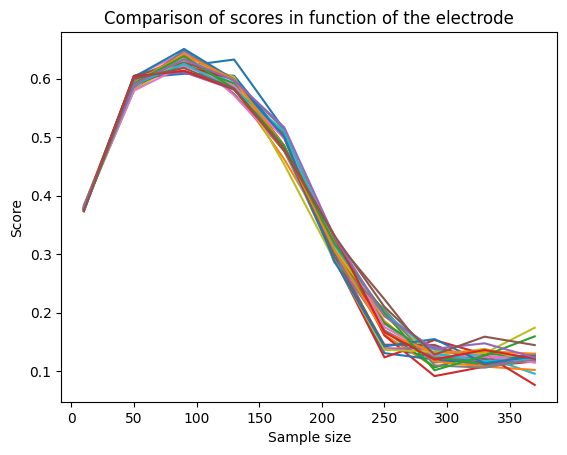

In [289]:
tailles_echantillon = range(10,400,40)
S = []
for electrode in range(Data_subjects[0].shape[0]):
    Scores = []
    for taille_echantillon  in tailles_echantillon:

        X = []
        for i in range(len(Data_subjects)):
            for x in range(len(Data_subjects[i][0])//taille_echantillon):
                X.append(np.array(Data_subjects[i][0][x*taille_echantillon:(x+1)*taille_echantillon]))

        X = np.array(X)
        y = np.array([[i for j in range(len(Data_subjects[i][0])//taille_echantillon)] for i in range(len(Data_subjects))]).flatten()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        clf = QuadraticDiscriminantAnalysis()
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        #print(f"Classifier QDA has a score of {score} for {taille_echantillon} sample size")
        Scores.append(score)
    S.append(Scores)
    plt.plot(tailles_echantillon,Scores)
plt.xlabel("Sample size")
plt.ylabel("Score")
plt.title("Comparison of scores in function of the electrode");

The chosen electrode doesn't matter, the results are the same for all of them.

***

### Task classification

Now we get into the more interesting part of the project, that is to classify the tasks. We will start by using the same approach as before, and then we will try to improve it.

In [290]:
sampling_rate = 250
number_of_classes = 4
trial_lenght = 4 # in seconds
trial_per_run = 48
number_of_runs = 6

classe_names = ["left_hand","right_hand","feet","tongue"]

Let's try to classify the class for one subject, and one session ! 

In [291]:
data_subject_1 = data[1]["session_T"]

In [292]:
from moabb.paradigms import MotorImagery

In [293]:
fmin = 4
fmax = 100
tmin = 0
tmax = None

events = ["right_hand", "left_hand"]
paradigm = MotorImagery(
    events=events, n_classes=len(events), fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax
)
subjects = [1]
X, target, _ = paradigm.get_data(dataset=dataset, subjects=subjects)

X = X[:,0,:] # we only take the first electrode

In [294]:
y = (target == "right_hand").astype(int)

X.shape

(288, 1001)

#### Using raw data for classification

Scoring: This time we will use the kappa score, which is a score that takes into account the chance level. It is defined as follows:
$\kappa = \frac{\Pr(a) - \Pr(e)}{1 - \Pr(e)}$

With Pr(a) the probability of agreement, and Pr(e) the probability of chance.
Link: https://fr.wikipedia.org/wiki/Kappa_de_Cohen



In [295]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

Scores = []
# iterate over classifiers
for x in range(5):
    S = []
    for name, clf in zip(names, classifiers):
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        S.append(score)
        #print(f"Classifier {name} has a score of {score}")
    Scores.append(S)

print("Mean of scores:")
for x in range(len(Scores[0])):
    print(f"Classifier {names[x]} has a kappa score of {(np.mean([Scores[y][x] for y in range(len(Scores))])-0.5)/0.5}")

Mean of scores:
Classifier Nearest Neighbors has a kappa score of -0.034482758620689724
Classifier Linear SVM has a kappa score of -0.13793103448275867
Classifier RBF SVM has a kappa score of -0.06896551724137934
Classifier Gaussian Process has a kappa score of 0.2068965517241379
Classifier Decision Tree has a kappa score of -0.10344827586206906
Classifier Random Forest has a kappa score of 0.096551724137931
Classifier Neural Net has a kappa score of -0.07586206896551728
Classifier AdaBoost has a kappa score of 0.0
Classifier Naive Bayes has a kappa score of -0.034482758620689724
Classifier QDA has a kappa score of -0.24137931034482762
Classifier LDA has a kappa score of -0.034482758620689724


The classifiers are rather bad. But in the first classification the QDA worked best with a sample size of ~100, we will troncate the data to this size and see if it improves the results.

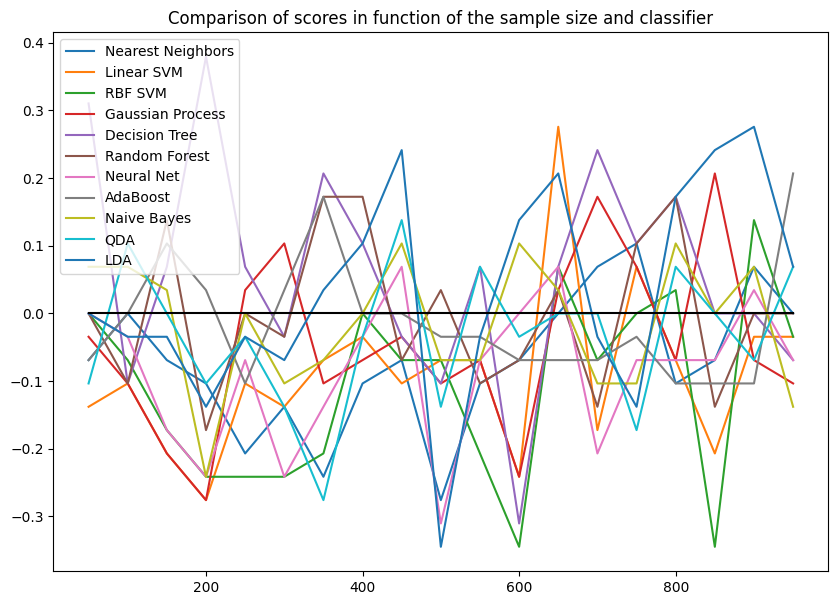

In [296]:
Scores = []
# iterate over classifiers

tailles_echantillon = range(50,1000,50)

for taille_echantillon in tailles_echantillon:
    X_tronque = X[:,0:x]
    X_train, X_test, y_train, y_test = train_test_split(
    X_tronque, y, test_size=0.2)
    S = []
    for name, clf in zip(names, classifiers):
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        S.append(score)
        #print(f"Classifier {name} has a score of {score}")
    Scores.append(S)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
for name, clf in zip(names, range(len(classifiers))):
    ax.plot(tailles_echantillon,[(Scores[y][clf]-0.5)*2 for y in range(len(Scores))],label=name)
ax.plot(tailles_echantillon,[0 for y in range(len(Scores))],"-",color="black")
plt.title("Comparison of scores in function of the sample size and classifier")
plt.legend();

There is no clear trend in the data, the classifiers perform poorly for all chunk sizes.

The approach that we used before is not very efficient, we will try to improve it by using a different approach.

***

### Feature extraction

We have been using the raw data to classify the tasks. We will now try to use features to classify the tasks.

#### Fourier transform

The EEG data is a time series, and seems to have some periodicity. We will try to extract the frequency components of the signal using the Fourier transform.

In [297]:
from scipy.fft import fft
X_fourier = fft(X,axis=1)

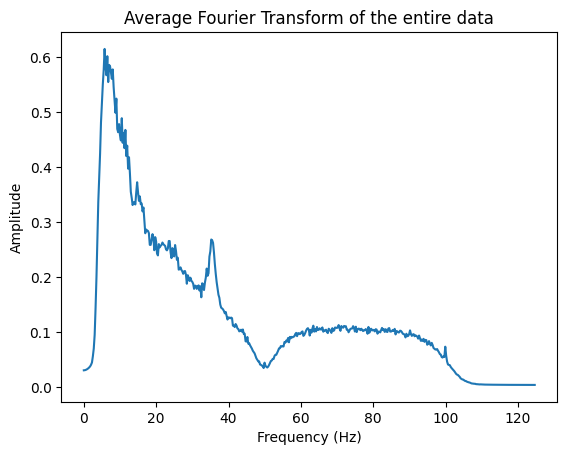

In [298]:
freq = np.fft.fftfreq(len(X_fourier[0]), 1/sampling_rate)[:X_fourier.shape[1]//2]

plt.title("Average Fourier Transform of the entire data")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.plot(freq,1/X_fourier.shape[1]*np.mean([np.abs(X_fourier[x,0:X_fourier.shape[1]//2]) for x in range(len(X_fourier))],axis=0));

We want to separate two classes, so we will compare the average Fourier transform of the two classes to see if they are separable. We will then use a classifier to classify the data.

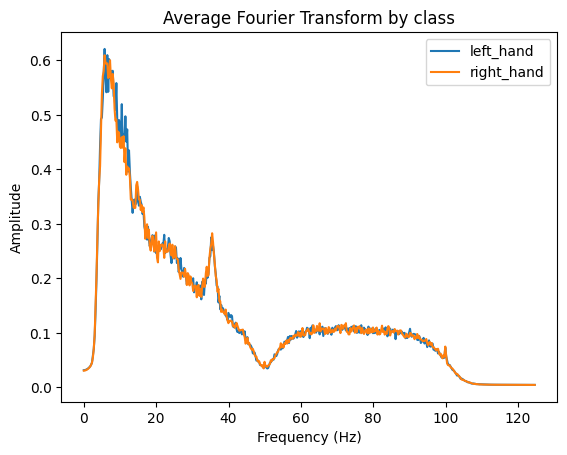

In [299]:
classes = np.unique(y)

plt.title("Average Fourier Transform by class")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
for classe in classes:
    plt.plot(freq,1/X_fourier.shape[1]*np.mean([np.abs(X_fourier[x,0:X_fourier.shape[1]//2]) for x in range(len(X_fourier)) if y[x]==classe],axis=0),label=classe_names[classe])
plt.legend();

There is not a great deal of differences between the two classes. Nonetheless, we will try to classify the data using a classifier.

We will have a deeper look at the Fourier transform of the two classes at frequencies between 0 and 25 Hz, since we observe the most amount of differences in this region.

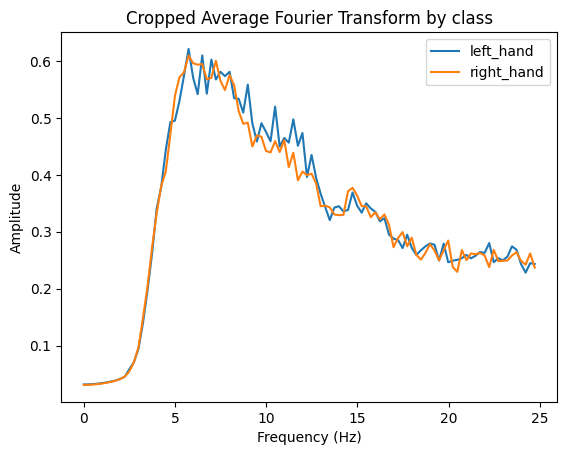

In [300]:
classes = np.unique(y)


plt.title("Cropped Average Fourier Transform by class")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
for classe in classes:
    plt.plot(freq[:100],1/X_fourier.shape[1]*np.mean([np.abs(X_fourier[x,:100]) for x in range(len(X_fourier)) if y[x]==classe],axis=0),label=classe_names[classe])
plt.legend();

With the little difference that exists, the classifier might be able to classify the classes. 

In [301]:
X_train, X_test, y_train, y_test = train_test_split(
    X_fourier.real[:,:100], y, test_size=0.2)

Scores = []
# iterate over classifiers
for x in range(5):
    S = []
    for name, clf in zip(names, classifiers):
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        S.append(score)
        #print(f"Classifier {name} has a score of {score}")
    Scores.append(S)

print("Mean of scores:")
for x in range(len(Scores[0])):
    print(f"Classifier {names[x]} has a kappa score of {(np.mean([Scores[y][x] for y in range(len(Scores))])-0.5)/0.5}")

Mean of scores:
Classifier Nearest Neighbors has a kappa score of 0.2068965517241379
Classifier Linear SVM has a kappa score of -0.034482758620689724
Classifier RBF SVM has a kappa score of -0.06896551724137934
Classifier Gaussian Process has a kappa score of 0.17241379310344818
Classifier Decision Tree has a kappa score of -0.24137931034482762
Classifier Random Forest has a kappa score of -0.08965517241379328
Classifier Neural Net has a kappa score of 0.07586206896551717
Classifier AdaBoost has a kappa score of -0.10344827586206906
Classifier Naive Bayes has a kappa score of 0.10344827586206895
Classifier QDA has a kappa score of 0.0
Classifier LDA has a kappa score of -0.10344827586206906


We have barely gained any performance, so let's try to extract more features from the data. Namely power spectral density.

##### PSD: Power Spectral Density

The power spectral density is the power of the signal at a certain frequency. It is defined as follows:
$PSD(f) = \frac{1}{N} \sum_{i=1}^{N} |X(f_i)|^2$

Where $X(f_i)$ is the Fourier transform of the signal at frequency $f_i$.

It is very close to the Fourier transform, we might be able to get some more information from it.

Let's obtain the power spectral density for each class !

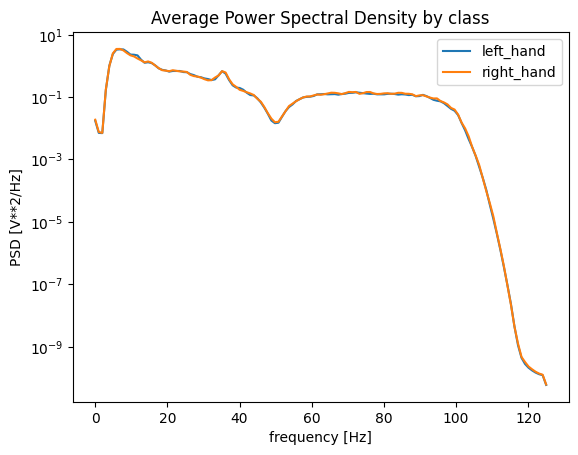

In [302]:
from scipy import signal

f, Pxx = signal.welch(X, fs=sampling_rate)
                            
for classe in classes:
    plt.semilogy(f, np.mean([Pxx[x] for x in range(len(Pxx)) if y[x]==classe],axis=0),label=classe_names[classe])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title("Average Power Spectral Density by class")
plt.legend();

There is virtually, no difference between the classes, it is very unlikely that we will be able to classify anything using these features. We wil use a different approach.

##### PCA

We will now try a different approach, namely PCA to reduce the dimensionality of the data, and then use a classifier to classify the components.

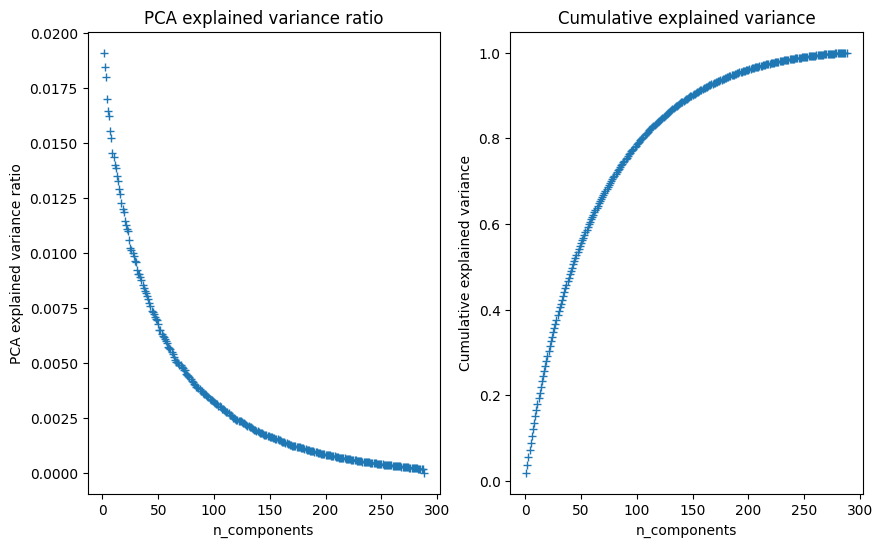

In [303]:
from sklearn.decomposition import PCA


pca = PCA()
pca.fit(X)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")
ax0.set_xlabel("n_components")
ax0.set_title("PCA explained variance ratio")


ax1.plot(
    np.arange(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), "+", linewidth=2)
ax1.set_ylabel("Cumulative explained variance")
ax1.set_title("Cumulative explained variance")
ax1.set_xlabel("n_components");

We will now extract the first that cumulatively add up to 80% of the variance, and then run our classifier on these components.

In [304]:
Number_of_useful_components = sum(np.cumsum(pca.explained_variance_ratio_) < 0.8)

In [305]:
pca = PCA(n_components=Number_of_useful_components)
X_PCA = pca.fit_transform(X)

In [306]:
X_train, X_test, y_train, y_test = train_test_split(
    X_PCA, y, test_size=0.2)

Scores = []
# iterate over classifiers
for x in range(10):
    S = []
    for name, clf in zip(names, classifiers):
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        S.append(score)
        #print(f"Classifier {name} has a score of {score}")
    Scores.append(S)

print("Mean of scores:")
for x in range(len(Scores[0])):
    print(f"Classifier {names[x]} has a kappa score of {(np.mean([Scores[y][x] for y in range(len(Scores))])-0.5)/0.5}")

Mean of scores:
Classifier Nearest Neighbors has a kappa score of 0.034482758620689946
Classifier Linear SVM has a kappa score of -0.06896551724137934
Classifier RBF SVM has a kappa score of -0.24137931034482762
Classifier Gaussian Process has a kappa score of -0.10344827586206906
Classifier Decision Tree has a kappa score of -0.2586206896551724
Classifier Random Forest has a kappa score of -0.024137931034482696
Classifier Neural Net has a kappa score of -0.12413793103448278
Classifier AdaBoost has a kappa score of -0.034482758620689724
Classifier Naive Bayes has a kappa score of -0.2758620689655171
Classifier QDA has a kappa score of -0.24137931034482762
Classifier LDA has a kappa score of -0.06896551724137934


This is not any better than the previous approach, we will try to extract more features from the data by changing the number of components.

We could try to classify the data using more principal components: 

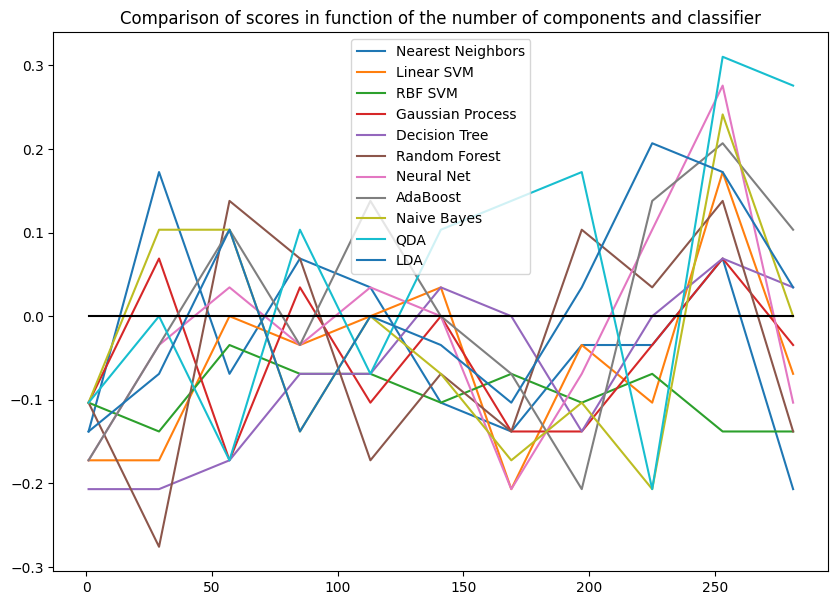

In [307]:
Scores = []
# iterate over classifiers

number_of_components =  np.arange(1,len(X),28)

for num_comp in number_of_components:
    #print("Number of components:",num_comp)
    pca = PCA(n_components=num_comp)
    X_PCA = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
    X_PCA, y, test_size=0.2)
    S = []
    for name, clf in zip(names, classifiers):
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        S.append(score)
        #print(f"Classifier {name} has a score of {score}")
    Scores.append(S)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
for name, clf in zip(names, range(len(classifiers))):
    ax.plot(number_of_components,[(Scores[y][clf]-0.5)*2 for y in range(len(Scores))],label=name)
ax.plot(number_of_components,[0 for y in range(len(Scores))],"-",color="black")
plt.title("Comparison of scores in function of the number of components and classifier")
plt.legend();

There is no trend in the performance. 

It seems that task classification is a much harder task than person classification. We will try to improve the results by using a different approach.

As a last attempt we will treat the eeg data as an image and use usual image processing techniques to classify the data.

***

##### Image processing

Since the data is not an image, we will have to interpret it as such. We will use the following approach:
- Each electrode is a pixel
- Each time step is a row

It is a little strange to use an image processing technique on a non-image, since we are not dealing with image data and also that the image will be very uneven. Also there might be some amount of information that is being lost in the spatial flattening, the eeg was recorded on the scalp, so the spatial information might be important: Electrodes that are close to each other might be more correlated than electrodes that are far away, and electrodes that are on either side of the head might highly correlated (since it is the same region on the other hemisphere).

![eeg format](eeg_data.jpg)

First we need to transform the data into an image format.

Let's get access to the data for all of the electrodes.

In [308]:
subjects = [1]
X, target, _ = paradigm.get_data(dataset=dataset, subjects=subjects)

In [309]:
y = (target=="right_hand").astype(int)

Let's display one image for each class, to get an idea of what the data looks like.

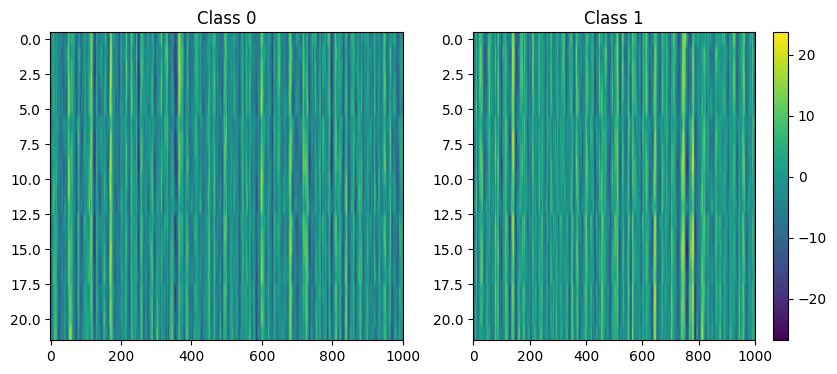

In [310]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].imshow(X[0],aspect="auto") #class 0, left hand
c = ax[1].imshow(X[1],aspect="auto") #class 1, right hand
plt.colorbar(c)
ax[0].set_title("Class 0")
ax[1].set_title("Class 1");

We will preprocess the data a little:

In [311]:
from keras.utils import to_categorical

#X = X.reshape(X.shape[0],-1) #flatten the data
X /= np.max(X) #normalize the data
y = to_categorical(y) #one-hot encoding

In [312]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

##### Deep-Learning: Convolutional Neural Network

Based on the following article: https://www.datacamp.com/tutorial/convolutional-neural-networks-python

Since our previous attempts were unsuccesful we will try to use a deep learning approach. We will use a convolutional neural network to classify the data.

We don't quite know what we are doing here exactly, but it was a good opportunity to learn about deep learning, as well as use highly sophisticated tools to classify the data.

In [313]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, ReLU
from keras.layers import Conv2D, MaxPooling2D

In [326]:
batch_size = 64
epochs = 20
num_classes = len(np.unique(y))

In [315]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(X.shape[1],X.shape[2],1),padding='same'))
cnn_model.add(ReLU())
cnn_model.add(MaxPooling2D((2, 2),padding='same'))
cnn_model.add(Conv2D(12, (3, 3), activation='linear',padding='same'))
cnn_model.add(ReLU())
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Conv2D(24, (3, 3), activation='linear',padding='same'))
cnn_model.add(ReLU())                  
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='linear'))
cnn_model.add(ReLU())                  
cnn_model.add(Dense(num_classes, activation='softmax'))

In [316]:
cnn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [317]:
train = cnn_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, y_test))

Epoch 1/20
4/4 [==============================] - 6s 1s/step - loss: 0.7132 - accuracy: 0.4913 - val_loss: 0.7000 - val_accuracy: 0.5000
Epoch 2/20
4/4 [==============================] - 3s 828ms/step - loss: 0.6977 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
4/4 [==============================] - 3s 824ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 4/20
4/4 [==============================] - 3s 801ms/step - loss: 0.6928 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5172
Epoch 5/20
4/4 [==============================] - 3s 781ms/step - loss: 0.6928 - accuracy: 0.5043 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/20
4/4 [==============================] - 4s 1s/step - loss: 0.6928 - accuracy: 0.5130 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/20
4/4 [==============================] - 3s 797ms/step - loss: 0.6924 - accuracy: 0.6000 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 8/20
4/4 [==========

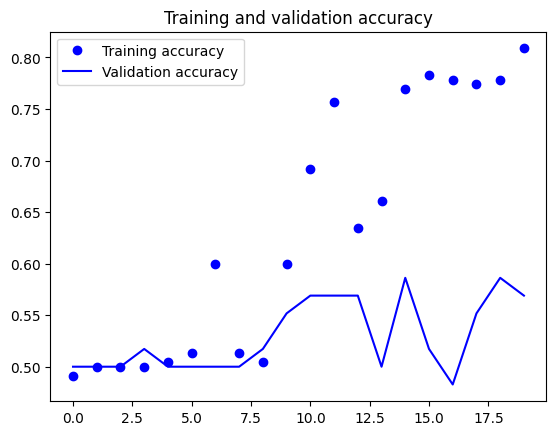

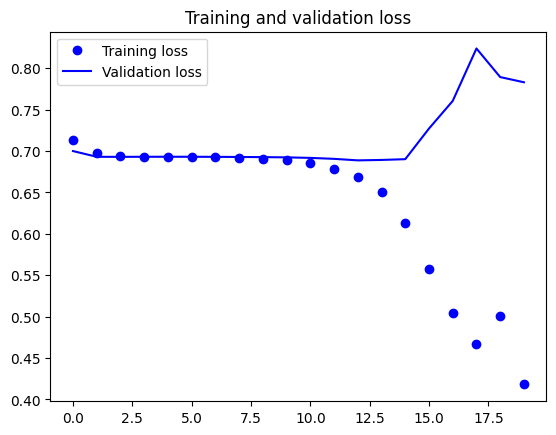

In [322]:
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs_range = range(len(accuracy))
plt.plot(epochs_range, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

There is significant overfitting. The cnn_model at least works on the training data. 

##### Reducing overfitting

We will reduce overfitting by reducing the number of parameters in the cnn_model. We will do this by reducing the number of filters in the convolutional layers, and by reducing the number of neurons in the dense layers, we will also add dropout layer (link:https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

In [323]:
cnn_model = Sequential()
cnn_model.add(Conv2D(20, kernel_size=(3, 3),activation='linear',input_shape=(X.shape[1],X.shape[2],1),padding='same'))
cnn_model.add(ReLU())
cnn_model.add(MaxPooling2D((2, 2),padding='same'))

cnn_model.add(Conv2D(10, (3, 3), activation='linear',padding='same'))
cnn_model.add(ReLU())
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

cnn_model.add(Conv2D(10, (3, 3), activation='linear',padding='same'))
cnn_model.add(ReLU())                  
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

cnn_model.add(Flatten())
cnn_model.add(Dense(11, activation='linear'))
cnn_model.add(ReLU()) 
cnn_model.add(Dropout(0.3))                 
cnn_model.add(Dense(num_classes, activation='softmax'))

In [324]:
cnn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [328]:
train = cnn_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, y_test))

Epoch 1/20
4/4 [==============================] - 3s 810ms/step - loss: 0.3346 - accuracy: 0.8304 - val_loss: 0.8655 - val_accuracy: 0.5517
Epoch 2/20
4/4 [==============================] - 5s 1s/step - loss: 0.3133 - accuracy: 0.8826 - val_loss: 1.0393 - val_accuracy: 0.5517
Epoch 3/20
4/4 [==============================] - 3s 721ms/step - loss: 0.3015 - accuracy: 0.8435 - val_loss: 1.1356 - val_accuracy: 0.5345
Epoch 4/20
4/4 [==============================] - 3s 703ms/step - loss: 0.2776 - accuracy: 0.8783 - val_loss: 0.9738 - val_accuracy: 0.5517
Epoch 5/20
4/4 [==============================] - 3s 794ms/step - loss: 0.2709 - accuracy: 0.8913 - val_loss: 1.1958 - val_accuracy: 0.5345
Epoch 6/20
4/4 [==============================] - 3s 733ms/step - loss: 0.2057 - accuracy: 0.9043 - val_loss: 1.3220 - val_accuracy: 0.5345
Epoch 7/20
4/4 [==============================] - 4s 958ms/step - loss: 0.1926 - accuracy: 0.9174 - val_loss: 1.2803 - val_accuracy: 0.5690
Epoch 8/20
4/4 [=======

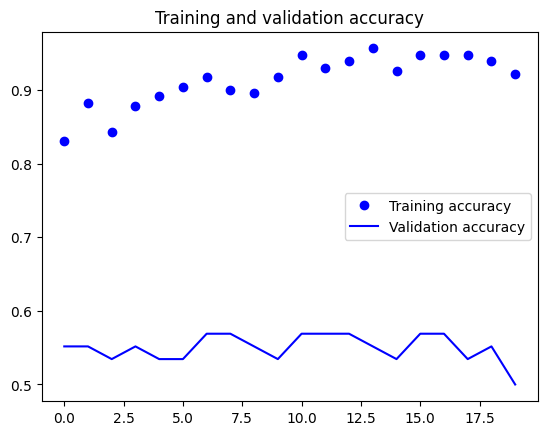

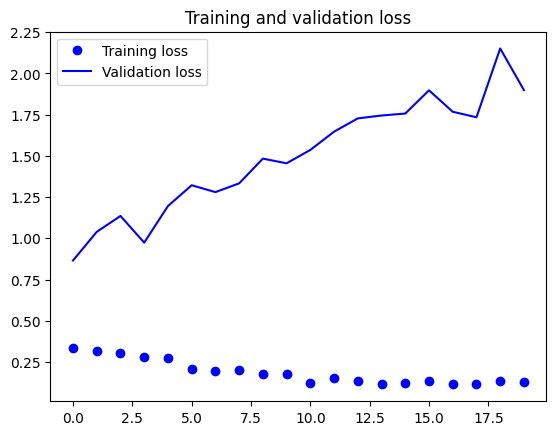

In [329]:
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs_range = range(len(accuracy))
plt.plot(epochs_range, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Maybe the performance would be better if we had more data. Therefore let's try to use the data from all of the subjects.

In [330]:
subjects = [1,2,3,4,5,6,7,8,9]
X, target, _ = paradigm.get_data(dataset=dataset, subjects=subjects)

In [331]:
y = (target=="right_hand").astype(int)

In [332]:
X /= np.max(X) #normalize the data
y = to_categorical(y) #one-hot encoding

In [333]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [334]:
cnn_model = Sequential()
cnn_model.add(Conv2D(20, kernel_size=(3, 3),activation='linear',input_shape=(X.shape[1],X.shape[2],1),padding='same'))
cnn_model.add(ReLU())
cnn_model.add(MaxPooling2D((2, 2),padding='same'))

cnn_model.add(Conv2D(8, (3, 3), activation='linear',padding='same'))
cnn_model.add(ReLU())
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

cnn_model.add(Conv2D(10, (3, 3), activation='linear',padding='same'))
cnn_model.add(ReLU())                  
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

cnn_model.add(Flatten())
cnn_model.add(Dense(10, activation='linear'))
cnn_model.add(ReLU()) 
cnn_model.add(Dropout(0.3))                 
cnn_model.add(Dense(num_classes, activation='softmax'))

In [335]:
cnn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [336]:
train = cnn_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, y_test))

Epoch 1/20
33/33 [==============================] - 30s 862ms/step - loss: 0.6934 - accuracy: 0.4949 - val_loss: 0.6933 - val_accuracy: 0.4778
Epoch 2/20
33/33 [==============================] - 44s 1s/step - loss: 0.6936 - accuracy: 0.5253 - val_loss: 0.6913 - val_accuracy: 0.5202
Epoch 3/20
33/33 [==============================] - 35s 1s/step - loss: 0.6887 - accuracy: 0.5321 - val_loss: 0.6861 - val_accuracy: 0.5588
Epoch 4/20
33/33 [==============================] - 54s 2s/step - loss: 0.6837 - accuracy: 0.5552 - val_loss: 0.6850 - val_accuracy: 0.5511
Epoch 5/20
33/33 [==============================] - 46s 1s/step - loss: 0.6706 - accuracy: 0.5808 - val_loss: 0.6800 - val_accuracy: 0.5742
Epoch 6/20
33/33 [==============================] - 51s 2s/step - loss: 0.6557 - accuracy: 0.6078 - val_loss: 0.6909 - val_accuracy: 0.5376
Epoch 7/20
33/33 [==============================] - 46s 1s/step - loss: 0.6472 - accuracy: 0.6189 - val_loss: 0.6801 - val_accuracy: 0.5761
Epoch 8/20
33/33 

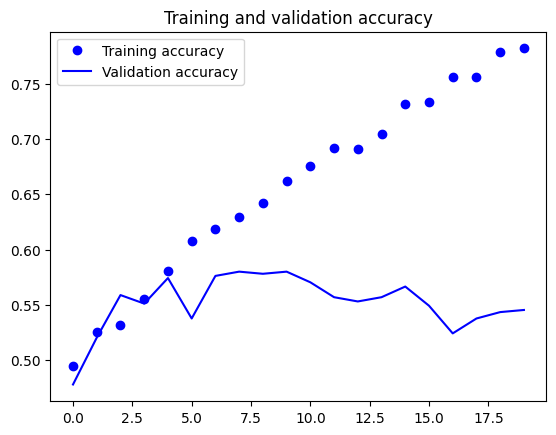

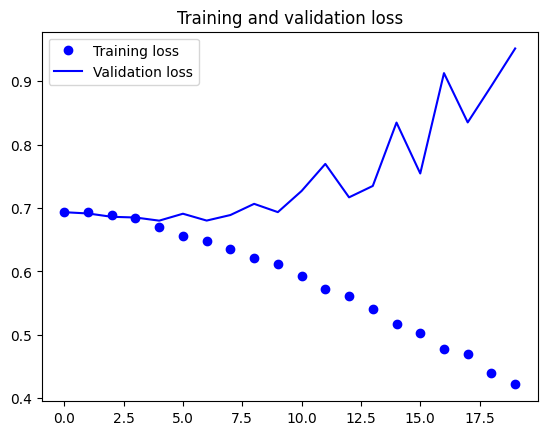

In [337]:
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs_range = range(len(accuracy))
plt.plot(epochs_range, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

It works  better ! But it is still overfitting to some extent. At least we can classify tasks with an above chance accuracy. This is the best we can do for now ! 

***

## Additional work

#### Compressed sensing: 

Usually when we record data, we need to sample it at a high frequency (about twice the highest frequency we want to capture, link: https://fr.wikipedia.org/wiki/Th%C3%A9or%C3%A8me_d%27%C3%A9chantillonnage). Through compressed sensing we are able to capture the data at a lower frequency, and then reconstruct the original signal. Compressed sensing works efficiently when the signal is sparse, such as with eeg data, and therefore is a good candidate for this problem.

We wanted to know wether it was possible to use compressed sensing as a way of encoding eeg data. This could have some usefulness as a feature extraction tool. 

We will use the following articles: 
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7374282/
- https://www.researchgate.net/publication/4274807_Compressed_Sensing_Framework_for_EEG_Compression

In [338]:
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx

We will start by sampling 10% of the data, and then reconstruct the signal using compressed sensing.

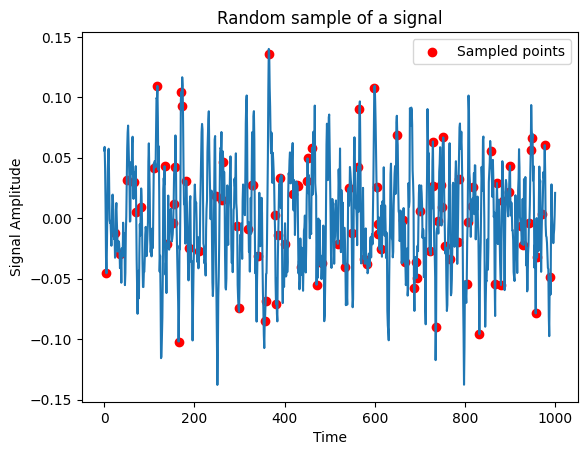

In [339]:
sample = X[0,0,:]

n = len(sample)

m = int(len(sample)/10) # 10% sample
ri = np.random.choice(n, m, replace=False) # random sample of indices
ri.sort()

extracted = sample[ri]
plt.title("Random sample of a signal")
plt.xlabel("Time")
plt.ylabel("Signal Amplitude")
plt.plot(sample)
plt.scatter(ri,extracted,color="red",label="Sampled points")
plt.legend();

Let's try to reconstruct the signal using compressed sensing.

In [340]:
A = spfft.idct(np.identity(n), norm='ortho', axis=0)
A = A[ri]

# do L1 optimization
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == extracted]
prob = cvx.Problem(objective, constraints)
result = prob.solve()

In [341]:
x = np.array(vx.value)
x = np.squeeze(x)
sig = spfft.idct(x, norm='ortho', axis=0)

We compare the reconstructed signal with the original signal.

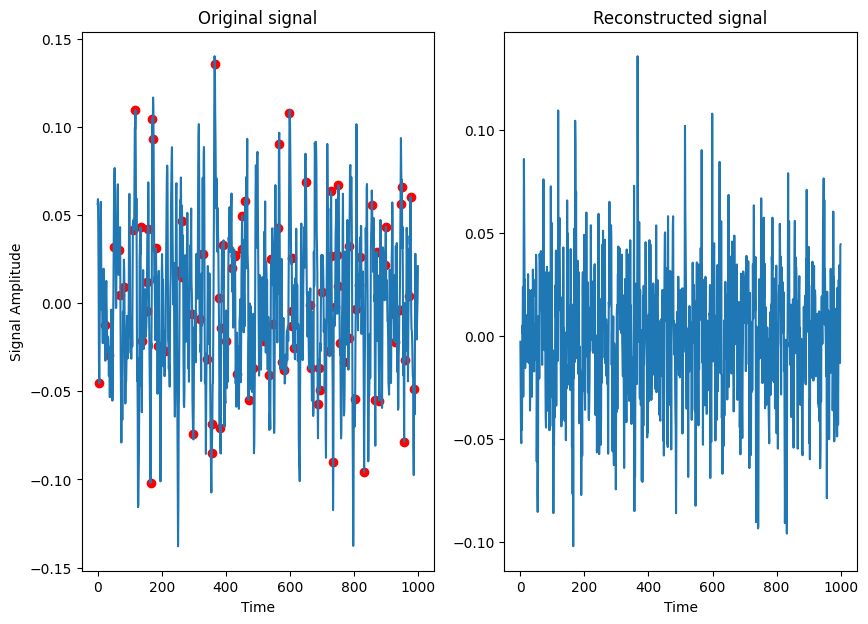

In [342]:
fig, ax = plt.subplots(1,2,figsize=(10,7))

ax[0].plot(sample)
ax[0].scatter(ri,extracted,color="red")
ax[0].set_title("Original signal")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Signal Amplitude")
ax[1].set_xlabel("Time")
ax[1].plot(sig)
ax[1].set_title("Reconstructed signal");

The signals look similar, but it is always hard to tell without quantifying the error. 

Let's now measure the error, and see how it varies with the number of samples.

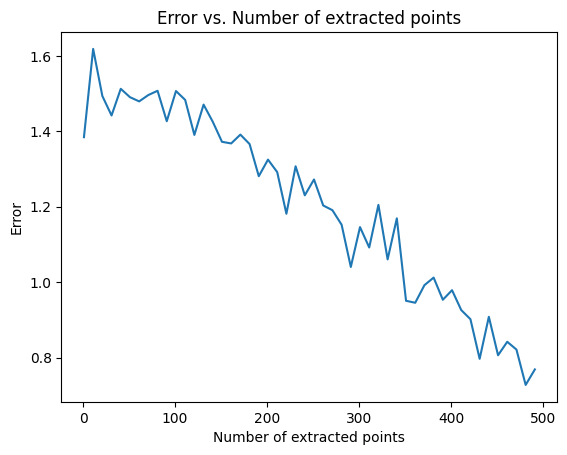

In [343]:
Extracted_lenght = np.arange(1,n//2,10)

errors = []

for m in Extracted_lenght:
    #print("[*]Extracting {} points".format(m))
    ri = np.random.choice(n, m, replace=False) # random sample of indices
    ri.sort()

    extracted = sample[ri]
    A = spfft.idct(np.identity(n), norm='ortho', axis=0)
    A = A[ri]

    # do L1 optimization
    vx = cvx.Variable(n)
    objective = cvx.Minimize(cvx.norm(vx, 1))
    constraints = [A*vx == extracted]
    prob = cvx.Problem(objective, constraints)
    result = prob.solve()
    x = np.array(vx.value)
    x = np.squeeze(x)
    sig = spfft.idct(x, norm='ortho', axis=0)
    error = np.linalg.norm(sample-sig,ord=2)
    errors.append(error)

plt.plot(Extracted_lenght,errors)
plt.title("Error vs. Number of extracted points")
plt.xlabel("Number of extracted points")
plt.ylabel("Error");


The error is low, and it seems that we can reconstruct the signal with a very low number of samples. As a next step we could try to use compressed sensing as a feature extraction tool to ameliorate the classification results.

***

#### Visualizing the data

As a last <b>fun</b> and <b>bonus</b> part, we will try to visualize some of the data in a nice way.

What we want to accomplish here is to get a better grasp of the data. By the nature of the brain, different regions are connected and communicate with one another. This is known as the brain's functional and structural connectivity. 

Since we use EEG data we will try to visualize the functional connectivity of the brain, by using the correlation between the electrodes, and how this correlation changes over time. We hope to find a difference between the classes, which would indicate that the brain is doing different things in the different classes, and might give us some intuition about how we would classify the data.

As for correlation we will use pearson correlation. <br>
${\displaystyle \rho _{X,Y}={\frac {\operatorname {cov} (X,Y)}{\sigma _{X}\sigma _{Y}}}}$, where X and Y are the two signals we want to correlate.


In [344]:
from mne_connectivity.viz import plot_connectivity_circle
from mne.viz import circular_layout

We want to get see how the correlation changes across time, therefore we will use the following approach:
- We will compute the correlation between each pair of electrodes for a certain time window
- Slide that time window by multiple time steps (not more than the video obiously) and repeat the process

In [345]:
window = 10

For the moment we will use data from a single suject. It is not much harder to do it for all of the subjects, but it is a little more time consuming.

In [346]:
subjects = [1]
X, target, _ = paradigm.get_data(dataset=dataset, subjects=subjects)
y = (target=="right_hand").astype(int)

In [347]:
def get_correlation(data,window):
    n = data.shape[1] #number of time points
    CORR = np.zeros((2*n//window,data.shape[0],data.shape[0])) #initialize array
    for i,x in enumerate(range(0,n-window,window//2)): #iterate over time points
        corr = np.corrcoef(data[:,x:x+window]) #correlation matrix
        CORR[i] = corr #append to list
    return CORR

It would be interesting to compare the different classes. Let's take the mean correlation for each time step, and plot it.

In [348]:
Mean_Correlation_trial1 = np.mean([get_correlation(X[i],window) for i in range(X.shape[0]) if y[i]==0],axis=0)
Mean_Correlation_trial2 = np.mean([get_correlation(X[i],window) for i in range(X.shape[0]) if y[i]==1],axis=0)

Now let's produce the video ! 

Finally we will use the images to create a video.

In [ ]:
import os 
from moabb.datasets.utils import find_intersecting_channels

video_path = "mean_video"

if not os.path.exists(video_path):
    os.mkdir(video_path)

label_names, _= find_intersecting_channels([dataset])

node_order = label_names

node_angles = circular_layout(label_names, node_order, start_pos=90)
for x in range(len(Mean_Correlation_trial1)):
    fig, ax = plt.subplots(figsize=(8, 8), facecolor='black',
                       subplot_kw=dict(polar=True))
    print(f"Processing frame: {x}/{len(Mean_Correlation_trial1)}")
    plot_connectivity_circle(Mean_Correlation_trial1[x], label_names,n_lines=100,
                            node_angles=node_angles,show=False,fig=fig,vmin=-1,vmax=1,subplot=121,colorbar=False,title="Left hand")
    plot_connectivity_circle(Mean_Correlation_trial2[x], label_names,n_lines=100,
                            node_angles=node_angles,show=False,fig=fig,vmin=-1,vmax=1,subplot=122,title="Right hand")
    fig.tight_layout()
    fig.savefig(f'{video_path}/connectivity{x}.png', facecolor=fig.get_facecolor(), edgecolor='none');

In [ ]:
import subprocess
subprocess.Popen("ffmpeg -framerate 30 -pattern_type glob -i 'mean_video/*.png' -pix_fmt yuv420p out.mp4")

Here is the final video:

<video controls src="out.mp4"/>

We observe some differences between the classes, but it is hard to tell what is going on, but still a beautiful result.

## END